In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_excel('AURN ST PAULS AIR.xlsx')

# Remove rows with missing values
df.dropna(inplace=True)

# Convert date time format
df['Date Time'] = pd.to_datetime(df['Date Time'])
df = df.sort_values(by='Date Time')

# Detect outliers
quantiles = df[['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']].quantile([0.25, 0.75])
for col in ['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']:
    q1 = quantiles.loc[0.25, col]
    q3 = quantiles.loc[0.75, col]
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# Standardize the data
continuous_cols = ['NOx', 'NO2', 'NO', 'PM10', 'PM2.5', 'O3', 'Temperature']
scaler = StandardScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

# Create time series features
df['hour'] = df['Date Time'].dt.hour
df['day_of_week'] = df['Date Time'].dt.dayofweek
df['day_of_month'] = df['Date Time'].dt.day
df['month'] = df['Date Time'].dt.month
df['year'] = df['Date Time'].dt.year



In [10]:
# Calculate the length of the training set (80% of the data)
train_len = int(0.8 * len(df))

# Split the dataset into training and test sets
train_df = df.iloc[:train_len]
test_df = df.iloc[train_len:]


# Separate the features and target variable
X_train = train_df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature', 'PM2.5', 'PM10', 'O3', 'NO', 'NO2']]
y_train = train_df["NOx"]
X_test = test_df[['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'Temperature', 'PM2.5', 'PM10', 'O3', 'NO', 'NO2']]
y_test = test_df["NOx"]

# Train and optimize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5, 9],
    'learning_rate': [0.1, 0.05]
}
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Use the optimized model for predictions
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

# Calculate the model performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mean Squared Error (MSE): 6.323905446300704e-05
Mean Absolute Error (MAE): 0.005315210017454129


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def train_and_predict_with_randomized_temperature(X_train, y_train, X_test, y_test):
    temperature_sample = df["Temperature"].sample(len(X_train), replace=True).reset_index(drop=True)
    X_train_temp = X_train.copy()
    X_train_temp["Temperature"] = temperature_sample

    # Remove or replace any NaN or infinite values
    X_train_temp = X_train_temp.replace([np.inf, -np.inf], np.nan)
    nan_mask = X_train_temp.isna().any(axis=1)
    X_train_temp = X_train_temp.dropna()
    y_train_temp = y_train[~nan_mask]

    model = GradientBoostingRegressor(n_estimators=1000, max_depth=9, learning_rate=0.1)
    model.fit(X_train_temp, y_train_temp)

    y_pred = model.predict(X_test)
    return y_pred

# Generate "deweathered" NOx concentrations
num_iterations = 5
y_pred_avg = np.zeros(len(y_test))

for _ in range(num_iterations):
    y_pred_temp = train_and_predict_with_randomized_temperature(X_train, y_train, X_test, y_test)
    y_pred_avg += y_pred_temp

# Calculate the average "deweathered" concentrations
y_pred_avg /= num_iterations



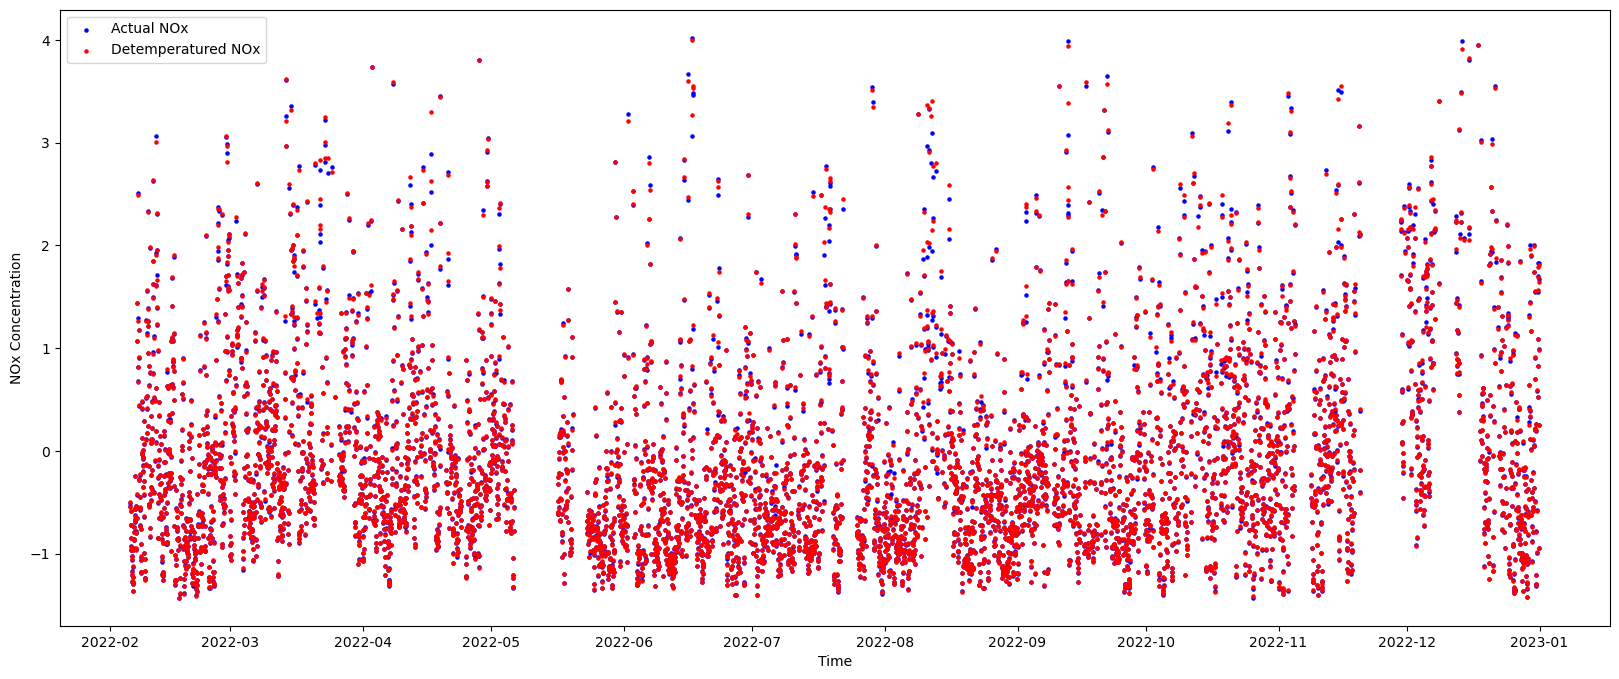

In [20]:
# Plot the actual NOx and "deweathered" NOx concentrations
plt.figure(figsize=(20, 8))
plt.scatter(test_df['Date Time'], y_test, color='blue', label='Actual NOx', s=5)
plt.scatter(test_df['Date Time'], y_pred_avg, color='red', label='Detemperatured NOx', s=5)
plt.xlabel('Time')
plt.ylabel('NOx Concentration')
plt.legend()
plt.show()
